In [1]:
!pip install vizdoom

In [2]:
!pip install opencv-python==4.5.5.62

In [3]:
!pip install gym==0.19.0

In [4]:
!pip install matplotlib==3.5.1 

In [1]:
from vizdoom import *
import random
import time 
import numpy as np

In [19]:
game = DoomGame()
game.load_config('game/VizDoom/scenarios/defend_the_center.cfg')
game.init()

In [3]:
actions = np.identity(3, dtype=np.uint8)
state = game.get_state()
state.game_variables

array([ 26., 100.])

In [20]:
episodes = 10 
for episode in range(episodes): 
    game.new_episode()
    while not game.is_episode_finished(): 
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions),4)
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 1.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 1.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 1.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
rewa

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [ ]:
game.close()

# Developing the Gym Environment

In [5]:
from gym import Env
from gym.spaces import Discrete, Box 
import cv2

In [6]:
class VizDoomGym(Env): 
    def __init__(self, render=False): 
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('game/VizDoom/scenarios/defend_the_center.cfg')
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()
        
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
    def step(self, action):
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    def render(): 
        pass
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    def close(self): 
        self.game.close()

In [7]:
env = VizDoomGym(render=True)

In [8]:
state = env.reset()

# Converting to greyscale

In [9]:
from matplotlib import pyplot as plt

In [10]:
from stable_baselines3.common import env_checker

C:\Users\zaoun\anaconda3\envs\mariorl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
env_checker.check_env(env)

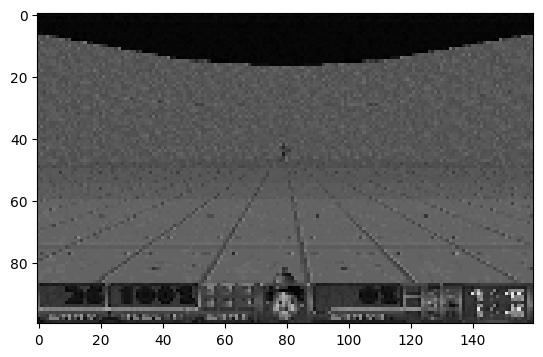

In [12]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

# Making a callback to save the model

In [14]:
import os 
from stable_baselines3.common.callbacks import BaseCallback

In [18]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [19]:
CHECKPOINT_DIR = './train/train_defend'
LOG_DIR = './logs/log_defend'

In [20]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Training 

In [13]:
from stable_baselines3 import PPO

In [14]:
env = VizDoomGym()

In [23]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [24]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_defend\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.3     |
|    ep_rew_mean     | 0.196    |
| time/              |          |
|    fps             | 21       |
|    iterations      | 1        |
|    time_elapsed    | 192      |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 84.4         |
|    ep_rew_mean          | 0.423        |
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 2            |
|    time_elapsed         | 1076         |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0068621924 |
|    clip_fraction        | 0.0317       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 132        |
|    ep_rew_mean          | 5.76       |
| time/                   |            |
|    fps                  | 4          |
|    iterations           | 11         |
|    time_elapsed         | 9184       |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.02439569 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.851     |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0499    |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0465    |
|    value_loss           | 0.152      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 180         |
|    ep_rew_mean          | 9.54        |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 21          |
|    time_elapsed         | 19183       |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.030186187 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.577      |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00133     |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0381     |
|    value_loss           | 0.122       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 180     

# Testing of our trained model

In [15]:
from stable_baselines3.common.evaluation import evaluate_policy

In [16]:
model = PPO.load('./train/train_defend/best_model_100000')

In [21]:
env = VizDoomGym(render=True)

In [22]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [ ]:
env.close()